## Dependencies for OpenAI 🦜️Langchain & 🏓Pinecone


In [137]:
# %pip install --upgrade --quiet  langchain-openai tiktoken chromadb langchain langchainhub

In [138]:
import os
import time
import dotenv
import openai
import getpass
import textwrap
import tempfile
import tiktoken
import json

from uuid import uuid4
from langchain import hub
from docx import Document
from openai import OpenAI
from dotenv import load_dotenv
from tqdm.autonotebook import tqdm
from langchain_openai import ChatOpenAI
from typing import List, Tuple, Optional
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from pinecone import Pinecone, ServerlessSpec
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.chains.mapreduce import MapReduceChain
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.callbacks import get_openai_callback
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains import MapReduceDocumentsChain, ReduceDocumentsChain
#os.environ['USER_AGENT'] = 'myagent'

## Keys Set up

In [139]:
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')
pinecone_api_key = os.getenv('PINECONE_API_KEY')
index_name = os.getenv('PINECONE_INDEX_NAME')



if openai_api_key:
    os.environ['OPENAI_API_KEY'] = openai_api_key
if pinecone_api_key:
    os.environ['PINECONE_API_KEY'] = pinecone_api_key  
if index_name:
    os.environ['PINECONE_INDEX_NAME'] = index_name    

#Verifications that the keys are loaded
#print(f"OpenAI API Key: {os.environ.get('OPENAI_API_KEY')}")
#print(f"Pinecone API Key: {os.environ.get('PINECONE_API_KEY')}")

In [140]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

## Vector Embeddings

In [141]:
os.environ["HUGGINGFACEHUB_API_TOKEN"]="HUGGINGFACEHUB_API_TOKEN"
embeddings = OpenAIEmbeddings(
    model="text-embedding-ada-002")

## Vector Database Set up

In [142]:
pc = Pinecone(api_key=pinecone_api_key)

existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

index = pc.Index(index_name)
#pc.list_indexes()

## Directory Loader


In [143]:

directory = 'Data Loader'
def load_docs(directory, tenantId):
    loader = DirectoryLoader(directory)
    docs = loader.load()
    
    for doc in docs:
        doc.metadata['tenantId'] = tenantId

        doc.metadata['filename'] = os.path.basename(doc.metadata['source'])
        print(doc.metadata['filename'])

    return docs

tenantId = "tenant3"
docs = load_docs(directory, tenantId)

Activity Logs Module ✓.docx


## Check Metadata

In [144]:
docs

[Document(metadata={'source': 'Data Loader/Activity Logs Module ✓.docx', 'tenantId': 'tenant3', 'filename': 'Activity Logs Module ✓.docx'}, page_content='support@vitafyhealth.com | 1-866-4-Vitafy\n\nActivity Logs Module\n\nSeptember, 2023\n\nOverview\n\nThe Activity Log serves as a comprehensive tool for monitoring all user actions within the platform. Gain insights into each action with detailed timestamps and user-specific activities for a thorough overview. \n\nFilter user activity\n\nUse the search bar to filter user activity by username, action, or time interval\n\nActivity log timestamps\n\nDetailed overview of user activities showcasing specific actions taken by each user along with corresponding timestamps.\n\nHow to\n\nFilter activity log\n\n\nTo filter activity log using search bar:\n\nSearch using user or activity\n\nClick the filter button to filter by interval\n\nUse the arrow button beside the timestamp column to filter in ascending/descending order.')]

## Chunks

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

## EmbeddedId

In [146]:
split_docs = []
chunk_ids = []

uploaded_documents_path = "do_not_delete_uploaded_documents.json"

if not os.path.exists(uploaded_documents_path):
        with open(uploaded_documents_path, "w") as f:
            json.dump({}, f)

with open(uploaded_documents_path, "r") as f:
        upload_documents = json.load(f)

for doc in docs:
        curr_split_docs = text_splitter.split_documents([doc])

        document_id = str(uuid4())

        # Create unique IDs for each chunk with the document ID as a prefix
        curr_chunk_ids = [f"{document_id}_chunk_{i+1}" for i in range(len(curr_split_docs))]

        split_docs = split_docs + curr_split_docs
        chunk_ids = chunk_ids + curr_chunk_ids

        upload_documents[document_id] =  {"fileName": doc.metadata['filename'], "id": document_id, "tenantId": tenantId}

## Vector Database Initializations

In [147]:
embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key)
vectorstore = PineconeVectorStore(index_name=index_name, embedding=embeddings)
vectorstore.add_documents(documents=split_docs, ids=chunk_ids)


['db8beba6-be04-4604-9ce4-e80af8e05b8c_chunk_1']

## 1. Stuff - Summary for Shorter Documents


In [148]:
retriever = vectorstore.as_retriever(
    #search_type="similarity",
    search_kwargs={
        "k": 1,
            "filter" : {
        'tenantId': {'$eq': 'tenant123'}  
    },
            }
)

llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
chain = load_summarize_chain(llm, chain_type="stuff")

#chain.run(split_docs)

In [149]:

# prompt template
prompt_template = """Write a concise summary of the following:
"{split_docs}"
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

# LLM chain
llm = ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo")
llm_chain = LLMChain(llm=llm, prompt=prompt)

#  StuffDocumentsChain
stuff_chain = StuffDocumentsChain(llm_chain=llm_chain, document_variable_name="split_docs")

#print(stuff_chain.run(split_docs))

## 2. Map_Reduce - Summary for Longer Documents

In [150]:
llm = ChatOpenAI(temperature=0)

# Map Reduce
map_template = """The following is a set of documents
{docs}
Based on this list of docs, please identify the main themes 
Helpful Answer:"""
map_prompt = PromptTemplate.from_template(map_template)
map_chain = LLMChain(llm=llm, prompt=map_prompt)

In [151]:
map_prompt = hub.pull("rlm/map-prompt")
map_chain = LLMChain(llm=llm, prompt=map_prompt)

/Users/ujjwal/Library/Python/3.9/lib/python/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [152]:
# Reduce
reduce_template = """The following is set of summaries:
{docs}
Take these and distill it into a final, consolidated summary of the main themes. 
Helpful Answer:"""
reduce_prompt = PromptTemplate.from_template(reduce_template)

In [153]:
reduce_prompt = hub.pull("rlm/map-prompt")
reduce_prompt

/Users/ujjwal/Library/Python/3.9/lib/python/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


ChatPromptTemplate(input_variables=['docs'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'map-prompt', 'lc_hub_commit_hash': 'de4fba345f211a462584fc25b7077e69c1ba6cdcf4e21b7ec9abe457ddb16c87'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['docs'], input_types={}, partial_variables={}, template='The following is a set of documents:\n{docs}\nBased on this list of docs, please identify the main themes \nHelpful Answer:'), additional_kwargs={})])

In [154]:
# Run chain
reduce_chain = LLMChain(llm=llm, prompt=reduce_prompt)

# Takes a list of documents, combines them into a single string, and passes this to an LLMChain
combine_documents_chain = StuffDocumentsChain(
    llm_chain=reduce_chain, document_variable_name="docs"
)

# Combines and iteratively reduces the mapped documents
reduce_documents_chain = ReduceDocumentsChain(
    # This is final chain that is called.
    combine_documents_chain=combine_documents_chain,
    # If documents exceed context for `StuffDocumentsChain`
    collapse_documents_chain=combine_documents_chain,
    # The maximum number of tokens to group documents into.
    token_max=4000,
)

In [155]:
# Combining documents by mapping a chain over them, then combining results
map_reduce_chain = MapReduceDocumentsChain(
    # Map chain
    llm_chain=map_chain,
    # Reduce chain
    reduce_documents_chain=reduce_documents_chain,
    # The variable name in the llm_chain to put the documents in
    document_variable_name="docs",
    # Return the results of the map steps in the output
    return_intermediate_steps=False,
)

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

In [156]:
#print(map_reduce_chain.run(split_docs))

## Map-Reduce: summarize long texts via parallelization

In [157]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

map_chain = map_prompt | llm | StrOutputParser()

In [158]:
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")

/Users/ujjwal/Library/Python/3.9/lib/python/site-packages/langsmith/client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [159]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

reduce_chain =  reduce_prompt | llm | StrOutputParser()

In [160]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Generated 1 documents.


In [161]:
docs

[Document(metadata={'source': 'Data Loader/Activity Logs Module ✓.docx', 'tenantId': 'tenant3', 'filename': 'Activity Logs Module ✓.docx'}, page_content='support@vitafyhealth.com | 1-866-4-Vitafy\n\nActivity Logs Module\n\nSeptember, 2023\n\nOverview\n\nThe Activity Log serves as a comprehensive tool for monitoring all user actions within the platform. Gain insights into each action with detailed timestamps and user-specific activities for a thorough overview. \n\nFilter user activity\n\nUse the search bar to filter user activity by username, action, or time interval\n\nActivity log timestamps\n\nDetailed overview of user activities showcasing specific actions taken by each user along with corresponding timestamps.\n\nHow to\n\nFilter activity log\n\n\nTo filter activity log using search bar:\n\nSearch using user or activity\n\nClick the filter button to filter by interval\n\nUse the arrow button beside the timestamp column to filter in ascending/descending order.')]

In [162]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

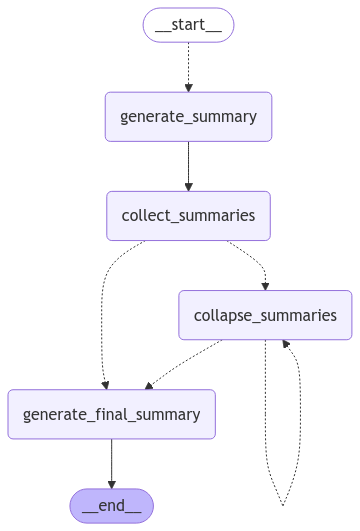

In [163]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [164]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['collect_summaries']
['generate_final_summary']


In [165]:
print(step)

{'generate_final_summary': {'final_summary': 'The Activity Logs Module in September 2023 allows users to monitor user actions with timestamps, filter activities by username, action, or time interval, and view specific actions taken by each user. Users can further filter the log by intervals or timestamps.'}}


## 3. Refine

In [167]:
chain = load_summarize_chain(llm, chain_type="refine")

In [168]:
prompt_template = """Write a concise summary of the following:
{text}
CONCISE SUMMARY:"""
prompt = PromptTemplate.from_template(prompt_template)

refine_template = (
    "Your job is to produce a final summary\n"
    "We have provided an existing summary up to a certain point: {existing_answer}\n"
    "We have the opportunity to refine the existing summary"
    "(only if needed) with some more context below.\n"
    "------------\n"
    "{text}\n"
    "------------\n"
    "Given the new context, refine the original summary in Italian"
    "If the context isn't useful, return the original summary."
)
refine_prompt = PromptTemplate.from_template(refine_template)
chain = load_summarize_chain(
    llm=llm,
    chain_type="refine",
    question_prompt=prompt,
    refine_prompt=refine_prompt,
    return_intermediate_steps=True,
    input_key="input_documents",
    output_key="output_text",
)
result = chain({"input_documents": split_docs}, return_only_outputs=True)

In [169]:
print(result["output_text"])

The Activity Logs Module on the Vitafy Health platform allows users to monitor all user actions with detailed timestamps and user-specific activities. Users can filter activity by username, action, or time interval, and view a detailed overview of user activities. The module also provides instructions on how to filter the activity log using the search bar and other features.


## Summary For Very Longer Documents


In [170]:
# Function to read PDF, DOCX, and TXT files from a specified directory and encoding
def load_documents_from_directory(directory: str) -> str:
    all_text = ""
    
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        if filename.endswith(".txt"):
            # Read .txt files
            with open(file_path, "r", encoding="utf-8") as file:
                all_text += file.read() + "\n\n"
        
        elif filename.endswith(".pdf"):
            # Read .pdf files using PyPDFLoader
            loader = PyPDFLoader(file_path)
            pdf_pages = loader.load_and_split()
            pdf_text = "\n\n".join(page.page_content for page in pdf_pages)
            all_text += pdf_text + "\n\n"
        
        elif filename.endswith(".docx"):
            # Read .docx files using python-docx
            doc = Document(file_path)
            docx_text = "\n\n".join([para.text for para in doc.paragraphs if para.text.strip()])
            all_text += docx_text + "\n\n"
    
    return all_text



In [171]:
text_content = "\n\n".join(doc.page_content for doc in docs)  

# Encoding and  the length of the dataset
encoding = tiktoken.encoding_for_model('gpt-3.5-turbo')
encoded_length = len(encoding.encode(text_content))

print(f"Total number of tokens: {encoded_length}")

Total number of tokens: 155


In [172]:
def get_chat_completion(messages, model='gpt-3.5-turbo'):
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message.content

In [173]:
def tokenize(text: str) -> List[str]:
    encoding = tiktoken.encoding_for_model('gpt-4-turbo')
    return encoding.encode(text)


# This function chunks a text into smaller pieces based on a maximum token count and a delimiter.
def chunk_on_delimiter(input_string: str,
                        max_tokens: int, delimiter: str) -> List[str]:
    chunks = input_string.split(delimiter)
    combined_chunks, _, dropped_chunk_count = combine_chunks_with_no_minimum(
        chunks, max_tokens, chunk_delimiter=delimiter, add_ellipsis_for_overflow=True
    )
    if dropped_chunk_count > 0:
        print(f"warning: {dropped_chunk_count} chunks were dropped due to overflow")
    combined_chunks = [f"{chunk}{delimiter}" for chunk in combined_chunks]
    return combined_chunks


# This function combines text chunks into larger blocks without exceeding a specified token count. It returns the combined text blocks, their original indices, and the count of chunks dropped due to overflow.
def combine_chunks_with_no_minimum(
        chunks: List[str],
        max_tokens: int,
        chunk_delimiter="\n\n",
        header: Optional[str] = None,
        add_ellipsis_for_overflow=False,
) -> Tuple[List[str], List[int]]:
    dropped_chunk_count = 0
    output = []  # list to hold the final combined chunks
    output_indices = []  # list to hold the indices of the final combined chunks
    candidate = (
        [] if header is None else [header]
    )  # list to hold the current combined chunk candidate
    candidate_indices = []
    for chunk_i, chunk in enumerate(chunks):
        chunk_with_header = [chunk] if header is None else [header, chunk]
        if len(tokenize(chunk_delimiter.join(chunk_with_header))) > max_tokens:
            print(f"warning: chunk overflow")
            if (
                    add_ellipsis_for_overflow
                    and len(tokenize(chunk_delimiter.join(candidate + ["..."]))) <= max_tokens
            ):
                candidate.append("...")
                dropped_chunk_count += 1
            continue  # this case would break downstream assumptions
        # estimate token count with the current chunk added
        extended_candidate_token_count = len(tokenize(chunk_delimiter.join(candidate + [chunk])))
        # If the token count exceeds max_tokens, add the current candidate to output and start a new candidate
        if extended_candidate_token_count > max_tokens:
            output.append(chunk_delimiter.join(candidate))
            output_indices.append(candidate_indices)
            candidate = chunk_with_header  # re-initialize candidate
            candidate_indices = [chunk_i]
        # otherwise keep extending the candidate
        else:
            candidate.append(chunk)
            candidate_indices.append(chunk_i)
    # add the remaining candidate to output if it's not empty
    if (header is not None and len(candidate) > 1) or (header is None and len(candidate) > 0):
        output.append(chunk_delimiter.join(candidate))
        output_indices.append(candidate_indices)
    return output, output_indices, dropped_chunk_count

In [174]:
def summarize(text: str,
                detail: float = 0,
                model: str = 'gpt-3.5-turbo',
                additional_instructions: Optional[str] = None,
                minimum_chunk_size: Optional[int] = 500,
                chunk_delimiter: str = ".",
                summarize_recursively=False,
                verbose=False):
    """
    Summarizes a given text by splitting it into chunks, each of which is summarized individually. 
    The level of detail in the summary can be adjusted, and the process can optionally be made recursive.

    Parameters:
    - text (str): The text to be summarized.
    - detail (float, optional): A value between 0 and 1 indicating the desired level of detail in the summary.
    0 leads to a higher level summary, and 1 results in a more detailed summary. Defaults to 0.
    - model (str, optional): The model to use for generating summaries. Defaults to 'gpt-3.5-turbo'.
    - additional_instructions (Optional[str], optional): Additional instructions to provide to the model for customizing summaries.
    - minimum_chunk_size (Optional[int], optional): The minimum size for text chunks. Defaults to 500.
    - chunk_delimiter (str, optional): The delimiter used to split the text into chunks. Defaults to ".".
    - summarize_recursively (bool, optional): If True, summaries are generated recursively, using previous summaries for context.
    - verbose (bool, optional): If True, prints detailed information about the chunking process.

    Returns:
    - str: The final compiled summary of the text.

    The function first determines the number of chunks by interpolating between a minimum and a maximum chunk count based on the `detail` parameter. 
    It then splits the text into chunks and summarizes each chunk. If `summarize_recursively` is True, each summary is based on the previous summaries, 
    adding more context to the summarization process. The function returns a compiled summary of all chunks.
    """

    # detail is set 
    assert 0 <= detail <= 1

    # interpolating the number of chunks based to get specified level of detail
    max_chunks = len(chunk_on_delimiter(text, minimum_chunk_size, chunk_delimiter))
    min_chunks = 1
    num_chunks = int(min_chunks + detail * (max_chunks - min_chunks))

    # adjusting the chunk_size based on interpolated number of chunks
    document_length = len(tokenize(text))
    chunk_size = max(minimum_chunk_size, document_length // num_chunks)
    text_chunks = chunk_on_delimiter(text, chunk_size, chunk_delimiter)
    if verbose:
        print(f"Splitting the text into {len(text_chunks)} chunks to be summarized.")
        print(f"Chunk lengths are {[len(tokenize(x)) for x in text_chunks]}")


    # setting system message
    system_message_content = "Rewrite this text in summarized form."
    if additional_instructions is not None:
        system_message_content += f"\n\n{additional_instructions}"

    accumulated_summaries = []
    for chunk in tqdm(text_chunks):
        if summarize_recursively and accumulated_summaries:
            # Creating a structured prompt for recursive summarization
            accumulated_summaries_string = '\n\n'.join(accumulated_summaries)
            user_message_content = f"Previous summaries:\n\n{accumulated_summaries_string}\n\nText to summarize next:\n\n{chunk}"
        else:
            # Directly passing the chunk for summarization without recursive context
            user_message_content = chunk

        # Constructing messages based on whether recursive summarization is applied
        messages = [
            {"role": "system", "content": system_message_content},
            {"role": "user", "content": user_message_content}
        ]

        # Assuming this function gets the completion and works as expected
        response = get_chat_completion(messages, model=model)
        accumulated_summaries.append(response)

    # Compiljng the final summary from partial summaries
    final_summary = '\n\n'.join(accumulated_summaries)

    return final_summary

## Combining Pinecone & LLM model


In [179]:
recursive_summary = summarize(text_content, detail=0.1, summarize_recursively=True)
print(recursive_summary)

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

The Activity Logs Module on vitafyhealth.com provides a tool to monitor user actions with detailed timestamps and user-specific activities. Users can filter activity by username, action, or time interval using the search bar. The log displays specific actions taken by each user with corresponding timestamps. To filter the activity log, users can search using the search bar, click the filter button for intervals, and use the arrow button to sort timestamps.


## Delete Entire Document

In [ ]:
for ids in index.list(prefix='839d309d-5191-40d6-a6ae-b7705d6fc611_chunk_1'):
    print(ids)
    index.delete(ids=ids)